In [115]:
#Fitting routine for identifying atom statistics in atomic resolution (S)TEM data

__author__ = 'Brian Shevitski'
import hyperspy.api as hs
import numpy as np
from scipy.ndimage.filters import maximum_filter,median_filter,gaussian_filter
from scipy.ndimage.morphology import binary_erosion

from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import os
import matplotlib.patches as patches
import matplotlib

plt.set_cmap("viridis")
plt.close()

def twoD_Gaussian(xdata_tuple, amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
    (x, y) = xdata_tuple                                                        
    xo = float(xo)                                                              
    yo = float(yo)                                                              
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)   
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)    
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)   
    g = offset + amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo)         
                        + c*((y-yo)**2)))                                   
    return g.ravel()

def detect_peaks(image,n_size):
    """
    Takes an image and detect the peaks usingthe local maximum filter.
    Returns a boolean mask of the peaks (i.e. 1 when
    the pixel's value is the neighborhood maximum, 0 otherwise)
    """
    #define neighborhood for local maxima
    neighborhood = np.ones((n_size,n_size)).astype(bool)
    
    #apply the local maximum filter; all pixel of maximal value 
    #in their neighborhood are set to 1
    local_max = maximum_filter(image, footprint=neighborhood)==image
    #local_max is a mask that contains the peaks we are 
    #looking for, but also the background.
    #In order to isolate the peaks we must remove the background from the mask.

    #we create the mask of the background
    background = (image==0)

    #a little technicality: we must erode the background in order to 
    #successfully subtract it form local_max, otherwise a line will 
    #appear along the background border (artifact of the local maximum filter)
    eroded_background = binary_erosion(background, structure=neighborhood, border_value=0)

    #we obtain the final mask, containing only peaks, 
    #by removing the background from the local_max mask
    detected_peaks = local_max - np.array(eroded_background).astype(int)
    return detected_peaks
    

In [100]:
filelist = []
for root, dirs, files in os.walk(os.getcwd()):
    for name in files:
        if '.emi' in name:
            filelist.append(os.path.join(root, name))
i = hs.load(filelist[0])

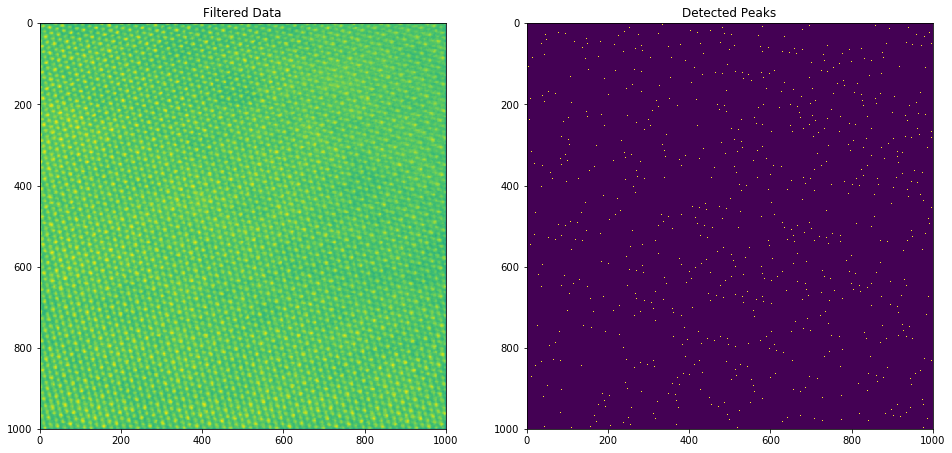

In [124]:
#some peaks do not show up due to monitor/aliasing/display artefacts
c=512
w=500
idata=i.data[c-w:c+w,c-w:c+w].astype(float)

filt=median_filter(idata,3)
filt=gaussian_filter(filt,1,mode='constant')

detected_peaks = detect_peaks(filt,10)

fig,ax =plt.subplots(1,2,figsize=(16,8))
ax[0].imshow(filt)
ax[0].set_title("Filtered Data")
ax[1].imshow(detected_peaks)
ax[1].set_title("Detected Peaks")

plt.show()

In [123]:
#verifying that all detected peaks are a single pixel
from skimage.measure import label, regionprops

h=[]
label_image = label(detected_peaks)
for region in regionprops(label_image):
    h.append(region.area)
h=np.array(h)    
print(h.min())
print(h.max())

1
1


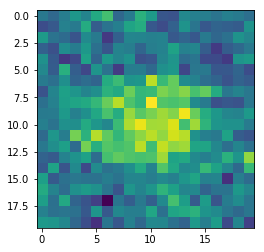

In [164]:
#finding optimal size for fitting region

temp_center_x = 423
temp_center_y = 693
fit_window = 20
plt.imshow(idata[int(temp_center_x-fit_window/2):int(temp_center_x+fit_window/2),
                 int(temp_center_y-fit_window/2):int(temp_center_y+fit_window/2)])
plt.show()

In [166]:
window_size=980 #lazy way to deal with edges of image (ignore them)
xsize=len(idata[0])
ysize=len(idata)
win_xmin=int((xsize/2)-(window_size/2))
win_xmax=int((xsize/2)+(window_size/2))
win_ymin=int((ysize/2)-(window_size/2))
win_ymax=int((ysize/2)+(window_size/2))

fitlist=[]
bounds=((0.,0.,0.,0.,0.,-180,-2**64),(2**64,fit_window,fit_window,fit_window,fit_window,180,2**64))

#fitting loop for all detected peaks, pretty slow
for x in range(win_xmin,win_xmax):
    for y in range(win_ymin,win_ymax):
        if detected_peaks[y,x]:
            dataforfit=idata[int(y-fit_window/2):int(y+fit_window/2),int(x-fit_window/2):int(x+fit_window/2)]
            xp = np.arange(0, len(dataforfit[0]), 1)
            yp = np.arange(0, len(dataforfit), 1)
            xp,yp = np.meshgrid(xp, yp)
            #params: Amplitude, center_X, center_Y, sigma_X, sigma_Y, angle, offset
            p0 = [dataforfit.max(),len(dataforfit)/2,len(dataforfit)/2,4.,4.,50.,dataforfit.min()]
            #parameter estimation/initialization
            coeff, var_matrix = curve_fit(twoD_Gaussian, (xp, yp), dataforfit.ravel(), p0=p0,bounds=bounds)
            fitlist.append(coeff)

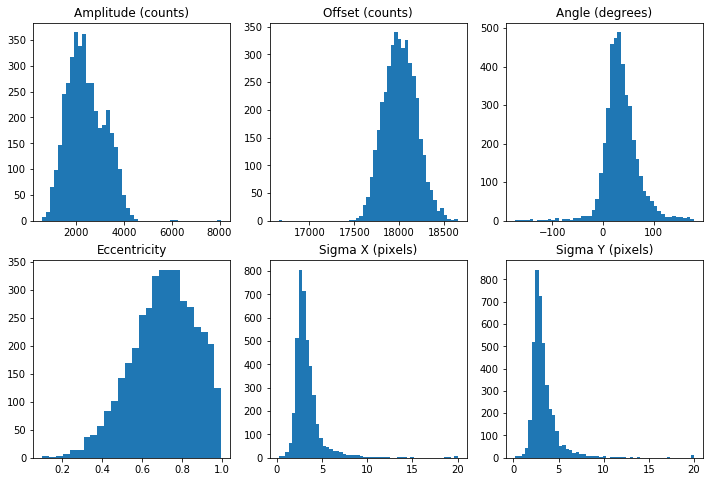

In [175]:
#Visual summary of peak fitting results
all_data = np.transpose(fitlist)

fig,ax =plt.subplots(2,3,figsize=(12,8))

ax[0,0].hist(all_data[0],bins='scott')
ax[0,0].set_title('Amplitude (counts)')

ax[0,1].hist(all_data[-1],bins='scott')
ax[0,1].set_title('Offset (counts)')

ax[0,2].hist(all_data[5],bins='scott')
ax[0,2].set_title('Angle (degrees)')

ecc1 = all_data[3]**2/all_data[4]**2
ecc2 = 1/ecc1
ecc = np.min([ecc1,ecc2],axis=0)
ecc = np.sqrt(1-ecc)

ax[1,0].hist(ecc,bins='scott')
ax[1,0].set_title('Eccentricity')

ax[1,1].hist(all_data[3],bins='scott')
ax[1,1].set_title('Sigma X (pixels)')

ax[1,2].hist(all_data[4],bins='scott')
ax[1,2].set_title('Sigma Y (pixels)')

plt.show()

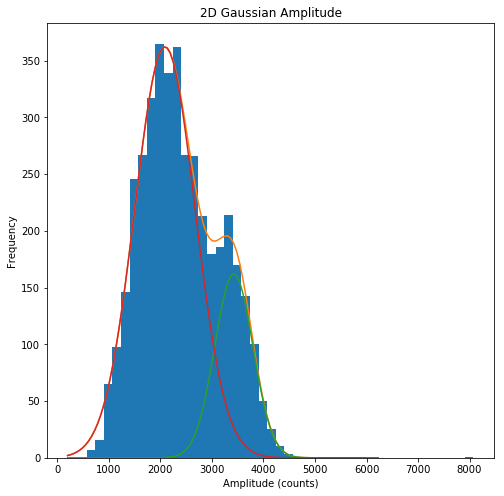

Amplitude Ratio (Z-Contrast): 1.640685757937686
Center Ratio (Lattice Geometry): 2.23263934137661


In [204]:
#Two gaussian fitting to bimodal amplitude

data = np.histogram(all_data[0],bins='scott')

def double_gaussian(xx,a0,a1,x0,x1,s0,s1):
    return a0*np.exp(-(xx-x0)**2/(2*s0**2)) + a1*np.exp(-(xx-x1)**2/(2*s1**2))

p0 = [data[0].mean(),data[0].mean(),data[1].mean(),data[1].mean(),data[1].std(),data[1].std()]

bin_borders = data[1]
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2

coeff, var_matrix = curve_fit(double_gaussian, bin_centers, data[0], p0=p0)

fig,ax = plt.subplots(1,1,figsize=(8,8))
ax.hist(all_data[0],bins='scott')

xx = np.linspace(200,6000,100)

yy = double_gaussian(xx,*coeff)
y0 = coeff[0]*np.exp(-(xx-coeff[2])**2/(2*coeff[4]**2))
y1 = coeff[1]*np.exp(-(xx-coeff[3])**2/(2*coeff[5]**2))

ax.plot(xx,yy)
ax.plot(xx,y0)
ax.plot(xx,y1)

ax.set_title('2D Gaussian Amplitude')
ax.set_ylabel('Frequency')
ax.set_xlabel('Amplitude (counts)')

plt.show()

print('Amplitude Ratio (Z-Contrast): ' + str(np.max([coeff[2]/coeff[3],coeff[3]/coeff[2]])))
print('Center Ratio (Lattice Geometry): ' + str(np.max([coeff[0]/coeff[1],coeff[1]/coeff[0]])))